<a href="https://colab.research.google.com/github/jmcaussade/Tarea1-Analitica-textual-con-ML/blob/main/Copia_de_Lab_01_Analitica_Textual_con_ML_Laboratorio_pre_procesamiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tarea 1 Alanítica textual con Machine Learning"
##Preprocesamiento de texto
### Integrantes:
#### - Jean Michel Caussade
#### - Sebastián Bobenrieth


## Instalación de librerias

In [106]:
pip install unidecode

Importar librerias necesarias


In [107]:
import os
import pandas as pd
import numpy as np
import re
# NLTK (Natural Language ToolKit) es una libreria para NLP
import nltk
# Existe extensiones que debemos descargar

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from collections import defaultdict
from collections import Counter
from unidecode import unidecode
from tqdm.notebook import tqdm
from itertools import chain

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Lectura base de datos en Google Drive

In [108]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
ruta_data_set = '/content/drive/My Drive/2024-02/Analitica_textual_con_ML/Tarea1/COAH_dataset.xlsx'
df = pd.read_excel(ruta_data_set)

Descripción de las variables a estudiar
1. **Id:** Identificador del comentario
2. **Rank:** Nota otorgada por el usuario (del 1 al 5, con 5 mayor satisfacción)
3. **Abstract:** Título del comentario (ingresado por el usuario)
4. **Review:** Cuerpo del comentario (ingresado por el usuario)


In [110]:
df.describe(include='all')

id         rank   abstract  \
count   1816.000000  1816.000000       1816   
unique          NaN          NaN       1681   
top             NaN          NaN  Excelente   
freq            NaN          NaN         15   
mean     908.500000     3.400881        NaN   
std      524.378362     1.440875        NaN   
min        1.000000     1.000000        NaN   
25%      454.750000     2.000000        NaN   
50%      908.500000     4.000000        NaN   
75%     1362.250000     5.000000        NaN   
max     1816.000000     5.000000        NaN   

                                                   review  
count                                                1816  
unique                                               1792  
top     La peor experiencia que he tenido en un hotel....  
freq                                                    2  
mean                                                  NaN  
std                                                   NaN  
min                                                   NaN  
25%                                                   NaN  
50%                                                   NaN  
75%                                                   NaN  
max                                                   NaN

# Análisis Exploratorio de Datos: Variable Objetivo

Para analizar el comportamiento de los datos de la variable objetivo (rating), generamos un gráfico de barras.

rank
5    531
4    489
1    312
3    285
2    199
Name: count, dtype: int64


<Axes: xlabel='rank'>

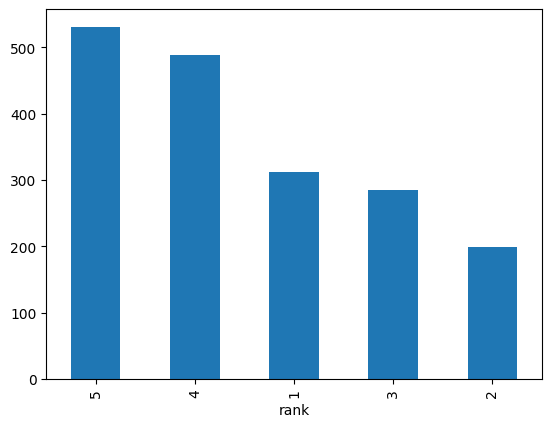

In [111]:
print(df['rank'].value_counts())
df['rank'].value_counts().plot(kind='bar')

In [112]:
print(df['rank'].unique())


[5 4 3 2 1]


Utilizaremos la definición clásica en análisis de sentimientos **recodificando** el rating en los siguientes valores:

1 y 2 -> 0 (Negativo)

3 -> 1 (Neutro)

4 y 5 -> 2 (Positivo)



rank
2    1020
0     511
1     285
Name: count, dtype: int64


<Axes: xlabel='rank'>

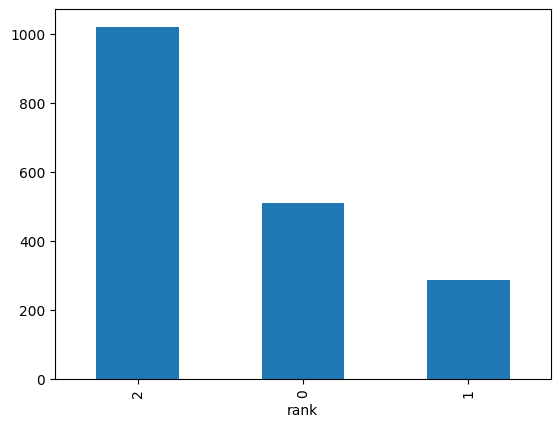

In [113]:
df['rank'] = df['rank'].replace({1: 0, 2: 0, 3: 1, 4: 2, 5: 2})

# Imprimir y graficar la distribucion de los ratings simplificados
print(df['rank'].value_counts())
df['rank'].value_counts().plot(kind='bar')

# Procesamiento de texto

Los pasos son:

1. **Limpieza**, la remoción del contenido no deseado.
2. **Normalización**, la conversión diferentes formas a una sola.
3. **Tokenización**, la separación del texto en tókenes (unidades mínimas, por ejemplo palabras).
4. Separación en **conjuntos de datos**: entrenamiento, validación, prueba.
5. Generación del **vocabulario**, la lista de tókenes conocidos.
6. **Numericalización**, el mapeo de tókenes a números enteros.

Estos pasos son comunes distintas aproximaciones al procesamiento del lenguaje.

## Limpieza

In [114]:
def limpiar(texto):
    puntuación = r'[,;.:¡!¿?@#$%&[\](){}<>~=+\-*/|\\_^`"\']'

    # signos de puntuación
    texto = re.sub(puntuación, ' ', texto)

    # dígitos [0-9]
    texto = re.sub('\d', ' ', texto)

    return texto

## Normalización


In [115]:
def normalizar(tokens):
    normalized_tokens = []
    for token in tokens:
      # todo a minúsculas
      texto = token.lower()

      # tildes y diacríticas
      texto = re.sub('á', 'a', texto)
      texto = re.sub('é', 'e', texto)
      texto = re.sub('í', 'i', texto)
      texto = re.sub('ó', 'o', texto)
      texto = re.sub('ú', 'u', texto)
      texto = re.sub('ü', 'u', texto)
      texto = re.sub('ñ', 'n', texto)
      normalized_tokens.append(texto)
    return normalized_tokens

## Unicode


In [116]:
def repazo_unicode(tokens):
    unicode_fixed_tokens = [unidecode(token) for token in tokens]
    return unicode_fixed_tokens

## Quizás corregir ortografía???

## Tokenización


In [117]:
def texto_tokenizer(texto):
    tokens = word_tokenize(texto)
    return tokens

## Lemmatizacion





In [118]:
nltk.download("wordnet")
nltk.download("omw-1.4")
wnl = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [119]:
def texto_lematization(texto_tokenizado, wnl):
    lemmatized_tokens = []
    for token in texto_tokenizado:
        # Check if the token is alphabetic
        if token.isalpha():
            # Lemmatize the token and add to the list
            lemmatized_token = wnl.lemmatize(token)
            lemmatized_tokens.append(lemmatized_token)
        else:
            # If it's not a word (e.g., punctuation), add it unchanged
            lemmatized_tokens.append(token)

    return lemmatized_tokens


### Stop Words

In [120]:
# Define additional stop words
additional_stopwords = {}

# Combine existing Spanish stop words with additional stop words
spanish_stopwords = set(stopwords.words('spanish')).union(additional_stopwords)

def rem_stopwords(tokens):
    texto_final = []
    for token, tag in pos_tag(tokens):
        if token.lower() not in spanish_stopwords:  # Convert token to lowercase for matching
            texto_final.append(token)
    return texto_final

rem_stopwords2 = lambda tokens: [token for token, tag in pos_tag(tokens) if token.lower() not in spanish_stopwords]

In [121]:
# tqdm.pandas()

# # Pre-procesamiento del Dataframe entero son approx. 15 min
# #df['comentario_tokenizado'] = df['comentario_tokenizado'].progress_apply(rem_stopwords) lentooooo!!!!
# df['con_stop_words'] = df['processed_review'].progress_apply(rem_stopwords2)

¡¡¡¡¡¡CELDA DE ABAJO SE DEBE CORRER 2 VECES!!!!!
La primera vez tira error y la segunda corre bien

---



In [122]:
def preprocesar1(texto):
    texto = limpiar(texto)
    texto = texto_tokenizer(texto)
    texto = rem_stopwords(texto)
    texto = texto_lematization(texto, wnl)
    texto = normalizar(texto)
    texto = repazo_unicode(texto)
    return texto

In [124]:
for index, row in df.iterrows():
    review_text = row['review']

    processed_review = preprocesar1(review_text)
    print(f"processed_review: {processed_review}")

    df.at[index, 'processed_review'] = processed_review

processed_review: ['bien', 'comente', 'propietarios', 'hora', 'abandonar', 'hotel', 'dudare', 'momento', 'recomendar', 'vez', 'hotel', 'albero', 'granada', 'situacion', 'respecto', 'centro', 'granada', 'mejor', 'propositos', 'perfecto', 'escapada', 'fin', 'semana', 'visita', 'alhambra', 'encuentra', 'carretera', 'paso', 'sierra', 'nevada', 'cercano', 'alhambra', 'zona', 'puede', 'encontrar', 'aparcamiento', 'encuentra', 'zona', 'segura', 'tranquila', 'parking', 'centro', 'granada', 'recomendaron', 'hotel', 'dijeron', 'caros', 'pudimos', 'movernos', 'centro', 'perfectamente', 'alli', 'habitaciones', 'limpias', 'camas', 'confortables', 'desayuno', 'espectacular', 'buenas', 'referencias', 'maravilloso', 'hotel', 'estrella', 'viajo', 'constantemente', 'superado', 'creces', 'expectativas', 'si', 'vuelvo', 'granada', 'dudare', 'hospedarme', 'mismo', 'hotel', 'muchas', 'gracias']
processed_review: ['do', 'dias', 'familia', 'reservando', 'do', 'habitaciones', 'desayuno', 'incluido', 'incluso',

In [125]:
df

id  rank                                          abstract  \
0        1     2                        Un hotel digno de mención!   
1        2     2  Recomendable 100%, sin lujos pero todo perfecto.   
2        3     1                                         Decepción   
3        4     2                      Por segunda vez, inmejorable   
4        5     2                                   No tan sorpresa   
...    ...   ...                                               ...   
1811  1812     2           remanso de paz en el corazón de Córdoba   
1812  1813     2             Oasis de paz, tranquilidad y belleza!   
1813  1814     2                            Un lugar para recordar   
1814  1815     2                                    Extraordinario   
1815  1816     2  Ojalá hubiese hoteles así en todas las ciudades.   

                                                 review  \
0     Como bien les comenté a los propietarios a la ...   
1     Estuvimos dos días con mi familia, reservando ...   
2     Habíamos escogido este hotel por las buenas op...   
3     Hemos vuelto por segunda vez a este estupendo ...   
4     He estado dos días en Granada por trabajo, soy...   
...                                                 ...   
1811  Hemos empezado el año con una estancia de tres...   
1812  Al atravesar el umbral de la puerta que conduc...   
1813  En este hotel todo son sensaciones y experienc...   
1814  Hemos pasado un par de noches en este exquisit...   
1815  El hotel es precioso, esta muy bien ubicado pa...   

                                       processed_review  
0     [bien, comente, propietarios, hora, abandonar,...  
1     [do, dias, familia, reservando, do, habitacion...  
2     [escogido, hotel, buenas, opiniones, verdad, h...  
3     [vuelto, segunda, vez, estupendo, hotel, grana...  
4     [do, dias, granada, trabajo, autonomo, busco, ...  
...                                                 ...  
1811  [empezado, ano, estancia, tres, noches, hotel,...  
1812  [atravesar, umbral, puerta, conduce, zaguan, h...  
1813  [hotel, sensaciones, experiencias, positivas, ...  
1814  [pasado, par, noches, exquisito, hotel, regent...  
1815  [hotel, precioso, bien, ubicado, recorrer, cor...  

[1816 rows x 5 columns]

## Vocabulario

#### Elementos más comunes


In [126]:
def counter(token_list):
  count = Counter(token_list)
  return count

#### Chaining lists of lists

In [127]:
def to_single_list(list_of_lists):
    return list(chain.from_iterable(list_of_lists))

In [128]:
token_list1 = to_single_list(df['processed_review'])

In [129]:
print(counter(token_list1))

Counter({'hotel': 2884, 'habitacion': 1224, 'bien': 1041, 'si': 1006, 'habitaciones': 901, 'personal': 773, 'dia': 648, 'desayuno': 584, 'solo': 493, 'piscina': 472, 'bano': 466, 'precio': 437, 'recepcion': 431, 'noche': 423, 'ma': 417, 'zona': 412, 'buena': 412, 'bastante': 398, 'comida': 395, 'do': 394, 'calidad': 384, 'aunque': 365, 'centro': 338, 'mejor': 330, 'servicio': 314, 'limpieza': 313, 'bueno': 297, 'ir': 291, 'trato': 287, 'playa': 284, 'toda': 278, 'semana': 276, 'mal': 274, 'fin': 272, 'dias': 269, 'ubicacion': 265, 'asi': 264, 'estrellas': 260, 'ademas': 256, 'vista': 255, 'puede': 253, 'buen': 249, 'ser': 248, 'ciudad': 245, 'verdad': 242, 'vez': 240, 'cama': 238, 'parking': 228, 'estancia': 228, 'menos': 227, 'cerca': 224, 'persona': 224, 'coche': 222, 'minutos': 221, 'alli': 217, 'siempre': 217, 'decir': 217, 'recomiendo': 216, 'amable': 213, 'mismo': 212, 'restaurante': 204, 'gente': 204, 'situado': 204, 'lugar': 203, 'agradable': 203, 'calle': 201, 'atencion': 201,

#### Class Vocabulario

In [130]:
class Vocab():
    def __init__(self, tóken_desconocido='<unk>', frecuencia_mínima=0.0, frecuencia_máxima=1.0,
                 longitud_mínima=1, longitud_máxima=np.inf, stop_words=[], límite_vocabulario=None):

        self.tóken_desconocido = tóken_desconocido
        self.frecuencia_mínima = frecuencia_mínima
        self.frecuencia_máxima = frecuencia_máxima
        self.longitud_mínima = longitud_mínima
        self.longitud_máxima = longitud_máxima
        self.stop_words = stop_words
        self.límite_vocabulario = límite_vocabulario

    def reducir_vocabulario(self, lote):
        contador_absoluto = Counter(chain(*lote))

        contador_documentos = Counter()

        for doc in lote:
            contador_documentos.update(set(doc))

        # frecuencia mínima
        if isinstance(self.frecuencia_mínima, int): # frecuencia de tóken
            vocabulario_mín = [tóken for tóken, frecuencia in contador_absoluto.most_common() if frecuencia >= self.frecuencia_mínima]
        else: # frecuencia de documento
            vocabulario_mín = [tóken for tóken, frecuencia in contador_documentos.most_common() if frecuencia/len(lote) >= self.frecuencia_mínima]

        # frecuencia máxima
        if isinstance(self.frecuencia_máxima, int): # frecuencia de tóken
            vocabulario_máx = [tóken for tóken, frecuencia in contador_absoluto.most_common() if self.frecuencia_máxima >= frecuencia]
        else: # frecuencia de documento
            vocabulario_máx = [tóken for tóken, frecuencia in contador_documentos.most_common() if self.frecuencia_máxima >= frecuencia/len(lote)]

        # intersección de vocabulario_mín y vocabulario_máx preservando el órden
        vocabulario = [tóken for tóken in vocabulario_mín if tóken in vocabulario_máx]

        # longitud
        vocabulario = [tóken for tóken in vocabulario if self.longitud_máxima >= len(tóken) >= self.longitud_mínima]

        # stop words
        vocabulario = [tóken for tóken in vocabulario if tóken not in self.stop_words]

        # límite
        vocabulario = vocabulario[:self.límite_vocabulario]

        return vocabulario

    def fit(self, lote):
        vocabulario = self.reducir_vocabulario(lote)

        if self.tóken_desconocido:
            vocabulario.append(self.tóken_desconocido)

        self.mapeo = {tóken: índice for índice, tóken in enumerate(vocabulario)}

        return self

    def transform(self, lote):
        if self.tóken_desconocido: # reemplazar
            return [[tóken if tóken in self.mapeo else self.tóken_desconocido for tóken in doc] for doc in lote]
        else: # ignorar
            return [[tóken for tóken in doc if tóken in self.mapeo] for doc in lote]

    def tókenes_a_índices(self, lote):
        lote = self.transform(lote)

        return [[self.mapeo[tóken] for tóken in doc] for doc in lote]

    def índices_a_tókenes(self, lote):
        mapeo_inverso = list(self.mapeo.keys())

        return [[mapeo_inverso[índice] for índice in doc] for doc in lote]

    def print_vocabulario(self):
        for tóken, índice in self.mapeo.items():
            print(f"{tóken}: {índice}")

    def __len__(self):
        return len(self.mapeo)


In [131]:
token_lists = df['processed_review'].tolist()

In [132]:
print(token_lists)

[['bien', 'comente', 'propietarios', 'hora', 'abandonar', 'hotel', 'dudare', 'momento', 'recomendar', 'vez', 'hotel', 'albero', 'granada', 'situacion', 'respecto', 'centro', 'granada', 'mejor', 'propositos', 'perfecto', 'escapada', 'fin', 'semana', 'visita', 'alhambra', 'encuentra', 'carretera', 'paso', 'sierra', 'nevada', 'cercano', 'alhambra', 'zona', 'puede', 'encontrar', 'aparcamiento', 'encuentra', 'zona', 'segura', 'tranquila', 'parking', 'centro', 'granada', 'recomendaron', 'hotel', 'dijeron', 'caros', 'pudimos', 'movernos', 'centro', 'perfectamente', 'alli', 'habitaciones', 'limpias', 'camas', 'confortables', 'desayuno', 'espectacular', 'buenas', 'referencias', 'maravilloso', 'hotel', 'estrella', 'viajo', 'constantemente', 'superado', 'creces', 'expectativas', 'si', 'vuelvo', 'granada', 'dudare', 'hospedarme', 'mismo', 'hotel', 'muchas', 'gracias'], ['do', 'dias', 'familia', 'reservando', 'do', 'habitaciones', 'desayuno', 'incluido', 'incluso', 'cogi', 'parking', 'privado', 'es

In [133]:
vocab = Vocab(
    tóken_desconocido='<unk>',
    frecuencia_mínima=50,
    frecuencia_máxima=500,
    longitud_mínima=3,
    longitud_máxima=10,
    stop_words=[],
    límite_vocabulario=None
)


In [134]:
vocabulario1 = vocab.fit(token_lists)

In [135]:
vocabulario1.print_vocabulario()

solo: 0
piscina: 1
bano: 2
precio: 3
recepcion: 4
noche: 5
zona: 6
buena: 7
bastante: 8
comida: 9
calidad: 10
aunque: 11
centro: 12
mejor: 13
servicio: 14
limpieza: 15
bueno: 16
trato: 17
playa: 18
toda: 19
semana: 20
mal: 21
fin: 22
dias: 23
ubicacion: 24
asi: 25
estrellas: 26
ademas: 27
vista: 28
puede: 29
buen: 30
ser: 31
ciudad: 32
verdad: 33
vez: 34
cama: 35
parking: 36
estancia: 37
menos: 38
cerca: 39
persona: 40
coche: 41
minutos: 42
alli: 43
siempre: 44
decir: 45
recomiendo: 46
amable: 47
mismo: 48
gente: 49
situado: 50
lugar: 51
agradable: 52
calle: 53
atencion: 54
excelente: 55
tan: 56
agua: 57
buffet: 58
pues: 59
llegar: 60
peor: 61
terraza: 62
pequena: 63
limpio: 64
unico: 65
lado: 66
parte: 67
ninos: 68
gusto: 69
sitio: 70
camas: 71
grande: 72
hostal: 73
unas: 74
sido: 75
aire: 76
cada: 77
hoteles: 78
pasar: 79
ver: 80
hacer: 81
puerta: 82
creo: 83
hace: 84
despues: 85
habia: 86
comer: 87
cordoba: 88
pequeno: 89
pasado: 90
general: 91
patio: 92
tener: 93
variedad: 94
encan

In [136]:
def filter_words_by_vocabulario(words, vocabulario):
    return [word for word in words if word in vocabulario.mapeo]

In [137]:
def contar_palabras_por_rank(df, rank):
    textos = df[df['rank'] == rank]['filtered_words']
    conteo_total = Counter(chain(*textos))
    return conteo_total

In [138]:
# Apply the function to each review
df['filtered_words'] = df['processed_review'].apply(lambda tokens: filter_words_by_vocabulario(tokens, vocabulario1))

In [139]:
df

id  rank                                          abstract  \
0        1     2                        Un hotel digno de mención!   
1        2     2  Recomendable 100%, sin lujos pero todo perfecto.   
2        3     1                                         Decepción   
3        4     2                      Por segunda vez, inmejorable   
4        5     2                                   No tan sorpresa   
...    ...   ...                                               ...   
1811  1812     2           remanso de paz en el corazón de Córdoba   
1812  1813     2             Oasis de paz, tranquilidad y belleza!   
1813  1814     2                            Un lugar para recordar   
1814  1815     2                                    Extraordinario   
1815  1816     2  Ojalá hubiese hoteles así en todas las ciudades.   

                                                 review  \
0     Como bien les comenté a los propietarios a la ...   
1     Estuvimos dos días con mi familia, reservando ...   
2     Habíamos escogido este hotel por las buenas op...   
3     Hemos vuelto por segunda vez a este estupendo ...   
4     He estado dos días en Granada por trabajo, soy...   
...                                                 ...   
1811  Hemos empezado el año con una estancia de tres...   
1812  Al atravesar el umbral de la puerta que conduc...   
1813  En este hotel todo son sensaciones y experienc...   
1814  Hemos pasado un par de noches en este exquisit...   
1815  El hotel es precioso, esta muy bien ubicado pa...   

                                       processed_review  \
0     [bien, comente, propietarios, hora, abandonar,...   
1     [do, dias, familia, reservando, do, habitacion...   
2     [escogido, hotel, buenas, opiniones, verdad, h...   
3     [vuelto, segunda, vez, estupendo, hotel, grana...   
4     [do, dias, granada, trabajo, autonomo, busco, ...   
...                                                 ...   
1811  [empezado, ano, estancia, tres, noches, hotel,...   
1812  [atravesar, umbral, puerta, conduce, zaguan, h...   
1813  [hotel, sensaciones, experiencias, positivas, ...   
1814  [pasado, par, noches, exquisito, hotel, regent...   
1815  [hotel, precioso, bien, ubicado, recorrer, cor...   

                                         filtered_words  
0     [hora, momento, vez, granada, situacion, centr...  
1     [dias, familia, incluido, incluso, parking, es...  
2     [buenas, verdad, centro, hacia, ruido, poder, ...  
3     [vez, estupendo, granada, relacion, calidad, p...  
4     [dias, granada, elegir, pues, situacion, cerca...  
...                                                 ...  
1811  [ano, estancia, tres, noches, lugar, tranquilo...  
1812  [puerta, olor, natural, patio, patio, calidad,...  
1813  [asi, ubicado, antigua, calle, ahora, junto, z...  
1814  [pasado, par, noches, trato, primera, planta, ...  
1815  [precioso, ubicado, cordoba, pie, cuenta, park...  

[1816 rows x 6 columns]

# Analisis exploratorio de datos: Información textual

In [141]:
# Step 1: Count the number of tokens in each row
df['token_count'] = df['processed_review'].apply(len)

# Step 2: Compute statistics grouped by 'rank'
grouped_stats = df.groupby('rank')['token_count'].agg(['min', 'max', 'mean', 'count']).reset_index()

# Rename columns for clarity
grouped_stats.columns = ['Rank', 'Min', 'Max', 'Average', 'Count']

# Add global statistics
global_stats = pd.DataFrame({
    'Rank': ['Global'],
    'Min': [df['token_count'].min()],
    'Max': [df['token_count'].max()],
    'Average': [df['token_count'].mean()],
    'Count': [len(df)]
})

# Concatenate global statistics with the grouped statistics
analisis_df = pd.concat([global_stats, grouped_stats], ignore_index=True)

# Print the new DataFrame
print(analisis_df)

     Rank  Min  Max    Average  Count
0  Global    6  631  61.920154   1816
1       0   10  430  79.187867    511
2       1    6  631  63.294737    285
3       2    6  394  52.885294   1020


# Nube de Palabras

In [142]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [143]:
def crear_wordcloud(conteo_palabras, titulo):
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate_from_frequencies(conteo_palabras)
    plt.figure(figsize=(10, 5))
    plt.title(titulo)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [144]:
conteo_rank_0 = contar_palabras_por_rank(df, 0)
conteo_rank_1 = contar_palabras_por_rank(df, 1)
conteo_rank_2 = contar_palabras_por_rank(df, 2)

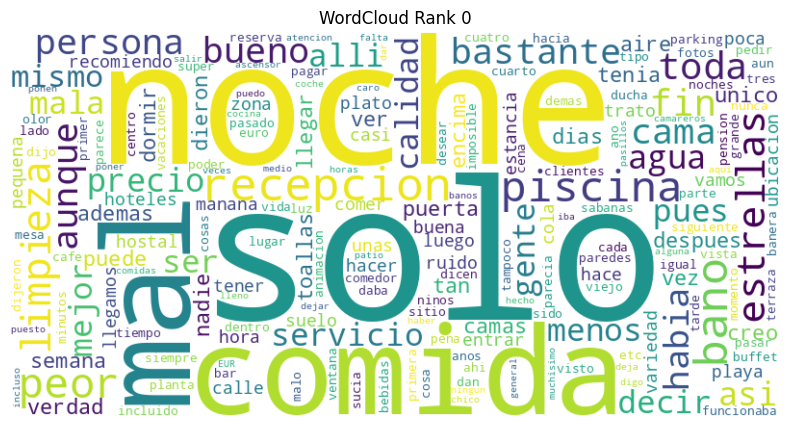

In [145]:
crear_wordcloud(conteo_rank_0, 'WordCloud Rank 0')

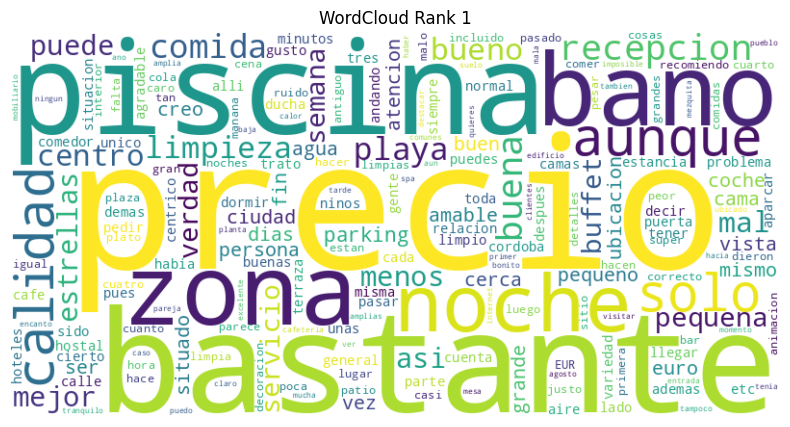

In [146]:
crear_wordcloud(conteo_rank_1, 'WordCloud Rank 1')

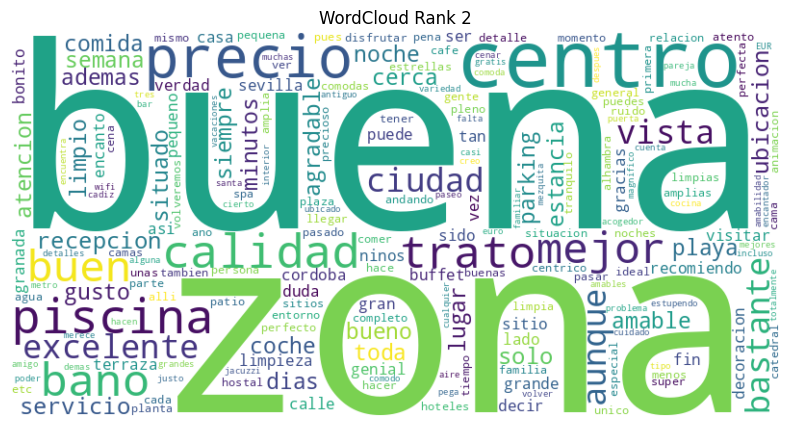

In [148]:
crear_wordcloud(conteo_rank_2, 'WordCloud Rank 2')

#Biagrama

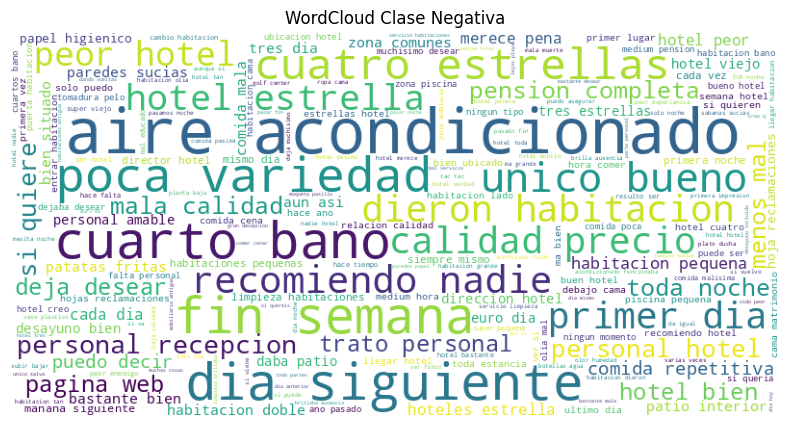

In [158]:
# Clase Negativa (0)
texto_unido_n = ' '.join(df[df['rank'] == 0]['processed_review'].sum())
wordcloud_n = WordCloud(width=800, height=400, background_color='white', collocation_threshold = 3).generate(texto_unido_n)
plt.figure(figsize=(10, 5))
plt.title('WordCloud Clase Negativa')
plt.imshow(wordcloud_n)
plt.axis('off')
plt.show()

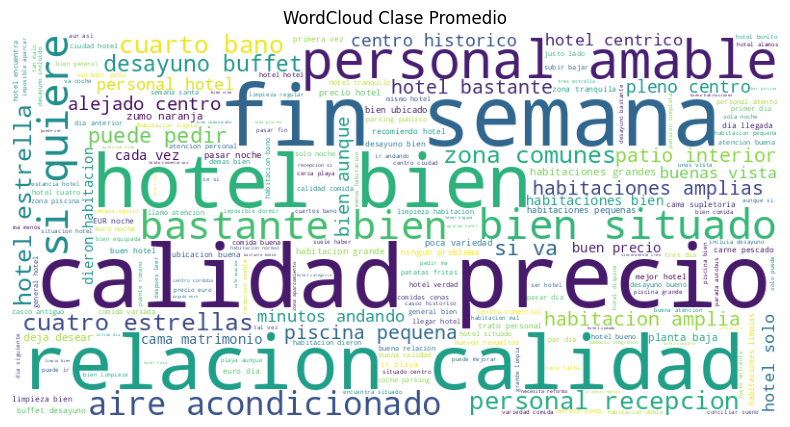

In [159]:
# Clase Promedio (1)
texto_unido_n = ' '.join(df[df['rank'] == 1]['processed_review'].sum())
wordcloud_n = WordCloud(width=800, height=400, background_color='white', collocation_threshold = 3).generate(texto_unido_n)
plt.figure(figsize=(10, 5))
plt.title('WordCloud Clase Promedio')
plt.imshow(wordcloud_n)
plt.axis('off')
plt.show()


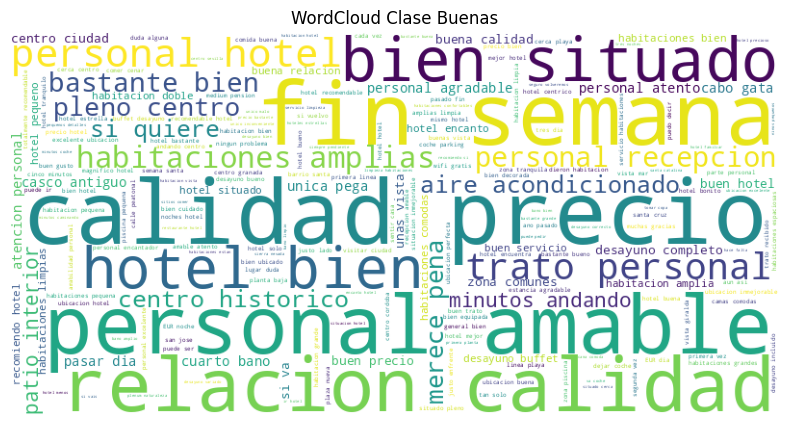

In [161]:
# Clase Buenas (2)
texto_unido_n = ' '.join(df[df['rank'] == 2]['processed_review'].sum())
wordcloud_n = WordCloud(width=800, height=400, background_color='white', collocation_threshold = 3).generate(texto_unido_n)
plt.figure(figsize=(10, 5))
plt.title('WordCloud Clase Buenas')
plt.imshow(wordcloud_n)
plt.axis('off')
plt.show()

In [ ]:
# Guardar DataFrame como pickle
df.to_pickle('/content/drive/My Drive/2024-02/Analitica_textual_con_ML/Tarea1/df_procesado.pkl')

# Para cargar
# df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/df_procesado.pkl')